In [117]:
import time

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from src.evaluate_regression import get_rankings, average_spearman


sns.set_theme(style="whitegrid")
sns.set_palette(palette="Set2")

np.random.seed(7)

In [118]:
# Constants for supervisors functions
FACTORS = ["dataset", "model", "tuning", "scoring"]
NEW_INDEX = "encoder"
TARGET = "cv_score"

# Load Data

In [119]:
print("Loading processed train and validation set ...")

X_train = pd.read_csv("../../data/preprocessed/X_train.csv")
y_train = pd.read_csv("../../data/preprocessed/y_train.csv")
X_val = pd.read_csv("../../data/preprocessed/X_val.csv")
X_val_original = pd.read_csv("../../data/preprocessed/X_val_original.csv")
y_val = pd.read_csv("../../data/preprocessed/y_val.csv")

print("Shape of X_train", X_train.shape)
print("Shape of y_train", y_train.shape)
print("Shape of X_val", X_val.shape)
print("Shape of X_val_original", X_val_original.shape)
print("Shape of y_val", y_val.shape)

Loading processed train and validation set ...
Shape of X_train (26989, 112)
Shape of y_train (26989, 1)
Shape of X_val (9065, 112)
Shape of X_val_original (9065, 5)
Shape of y_val (9065, 1)


In [120]:
X_train.head(5)

,dataset,model_DTC,model_KNC,model_LGBMC,model_LR,model_SVC,tuning_full,tuning_model,tuning_no,scoring_ACC,...,non_categorical_features_count,ratio_of_categorical_features_to_all,sum_of_all_categories,categorical_target_variables_count,non_categorical_target_variables_count,categorical_target_values_sum,total_feature_count,min_number_of_categories_per_cat_feature,max_number_of_categories_per_cat_feature,avg_number_of_categories_per_cat_feature
0,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681
1,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681
2,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681
3,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681
4,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681


# Testing different baseline models

In [121]:
def get_average_spearman(X_val_original, y_val, y_pred) -> float:

    df_pred = pd.concat([X_val_original, y_val, y_pred], axis=1)
    rankings_test = get_rankings(df_pred, factors=FACTORS, new_index=NEW_INDEX, target="cv_score")
    rankings_pred = get_rankings(df_pred, factors=FACTORS, new_index=NEW_INDEX, target="cv_score_pred")
    avg_spearman = average_spearman(rankings_test, rankings_pred)

    return avg_spearman

In [122]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoCV
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score

#######################################################
rf = RandomForestRegressor(n_jobs=-1, random_state=42)
dt = DecisionTreeRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
lassocv = LassoCV(n_jobs=-1, random_state=42, max_iter=20000)
mlp = MLPRegressor(random_state=42)
svr = SVR()

models = [rf, dt, xgb, lassocv, mlp, svr]
#######################################################

def fit_and_predict(models: list, X_train, y_train, X_val, y_val, X_val_original, model_types: str):

    model_string_list = []
    spearman_list = []
    fitted_models = []
    fit_time = []
    pred_scoring_time = []  # Contains time taken for prediction AND average spearman scoring only!
    mse = []
    r2 = []

    for model in models:
        model_string = str(model).split("(")[0]
        model_string_list.append(model_string)
        print(f"Fitting {model_string} ...")
        start = time.time()
        # Fit model
        model.fit(X_train, y_train.values.flatten())
        fit_time.append(np.round((time.time() - start), 4))

        # Predicting
        start = time.time()
        print("Making prediction on validation set ...")
        y_pred = pd.DataFrame(model.predict(X_val), columns=["cv_score_pred"])

        # Scoring
        print("Get average spearman score ...")
        spearman = get_average_spearman(X_val_original, y_val, y_pred)
        print(f"Average spearman score: {spearman:.4f}")

        pred_scoring_time.append(np.round((time.time() - start), 4))

        print("Append results ...\n")
        spearman_list.append(spearman)
        fitted_models.append(model)
        mse.append(mean_squared_error(y_true=y_val, y_pred=y_pred))
        r2.append(r2_score(y_true=y_val, y_pred=y_pred))

    # Build result dataframe
    res = pd.DataFrame({
        "model": model_string_list,
        "fit_time": fit_time,
        "pred_scoring_time": pred_scoring_time,
        "average_spearman": spearman_list,
        "mse": mse,
        "r2": r2,
        "model_type": model_types
    })

    return res, fitted_models


In [123]:
res, fitted_models = fit_and_predict(models, X_train, y_train, X_val, y_val, X_val_original, model_types="baseline")
res

Fitting RandomForestRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.5426
Append results ...

Fitting DecisionTreeRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.5061
Append results ...

Fitting XGBRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.4115
Append results ...

Fitting LassoCV ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.0850
Append results ...

Fitting MLPRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.2020
Append results ...

Fitting SVR ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.2223
Append results ...



,model,fit_time,pred_scoring_time,average_spearman,mse,r2,model_type
0,RandomForestRegressor,25.9861,1.6885,0.542643,0.004722,0.908113,baseline
1,DecisionTreeRegressor,0.7473,2.0678,0.506089,0.007293,0.858075,baseline
2,XGBRegressor,12.0558,2.3166,0.411495,0.003308,0.935633,baseline
3,LassoCV,19.0179,1.7221,0.085040,0.023994,0.533084,baseline
4,MLPRegressor,6.9406,1.5393,0.201974,0.010405,0.797528,baseline
5,SVR,19.5240,10.9357,0.222268,0.013685,0.733685,baseline


In [124]:
def plot_results(df, savefigs=False):
    col_list = [column for column in df.columns if column not in ["model_type", "model"]]

    for col in col_list:
        plt.figure(figsize=(5, 4), dpi=128)
        plt.title(f"Comparison of '{col}' of different models on hold-out-set", size=14)
        if len(df.model_type.unique()) > 1:
            g = sns.barplot(data=df.sort_values([col], ascending=False), y="model", x=col, edgecolor="black",
                            hue="model_type", errorbar=None)
        else:
            g = sns.barplot(data=df.sort_values([col], ascending=False), y="model", x=col, edgecolor="black", errorbar=None)

        lgd = g.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Data Transformation')

        if savefigs:
            plt.savefig(f"plots/fig_{col}.svg", bbox_extra_artists=(lgd,), bbox_inches='tight')

        plt.show()


In [125]:
#plot_results(res)

# Testing different models after Feature Selection

In [127]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression, SelectFromModel, RFECV

def fe_using_mi(X_train, y_train, num_features = 40, verbosity=0, keep_encoder_dims=True):
    enc_dims = []

    if keep_encoder_dims:
        enc_dims = [col for col in X_train.columns if col.startswith("enc_dim")]
    # Perform feature selection using Mutual Information Regression
    selector = SelectKBest(mutual_info_regression, k=num_features)
    X_new = selector.fit_transform(X_train.drop(enc_dims, axis=1), y_train.values.flatten())

    selected_features_names = selector.get_feature_names_out()
    selected_features_names = list(selected_features_names)

    # Append enc dim again
    X_new = pd.DataFrame(X_new, columns=selected_features_names, index=X_train.index)

    if keep_encoder_dims:
        X_new[enc_dims] = X_train[enc_dims]

    # Append encoder dims to selected features
    selected_features_names = selected_features_names + enc_dims

    if verbosity > 0:
        # Print the selected features
        print("Selected Features:")
        for feature_name in selected_features_names:
            print(f"- {feature_name}")

    return X_new, selected_features_names


def fe_using_model(X_train, y_train, max_features = 40, verbosity=0, keep_encoder_dims=True):

    enc_dims = []

    if keep_encoder_dims:
        enc_dims = [col for col in X_train.columns if col.startswith("enc_dim")]
    # Perform feature selection using Mutual Information Regression
    selector = SelectFromModel(estimator=RandomForestRegressor(random_state=42, n_jobs=-1), max_features=max_features)
    X_new = selector.fit_transform(X_train.drop(enc_dims, axis=1), y_train.values.flatten())

    selected_features_names = selector.get_feature_names_out()
    selected_features_names = list(selected_features_names)

    # Append enc dim again
    X_new = pd.DataFrame(X_new, columns=selected_features_names, index=X_train.index)

    if keep_encoder_dims:
        X_new[enc_dims] = X_train[enc_dims]

    # Append encoder dims to selected features
    selected_features_names = selected_features_names + enc_dims

    if verbosity > 0:
        # Print the selected features
        print("Selected Features:")
        for feature_name in selected_features_names:
            print(f"- {feature_name}")

    return X_new, selected_features_names




# Apply Feature Selection using MI

In [128]:
X_train_fe_mi, selected_features = fe_using_mi(X_train, y_train, num_features=10, keep_encoder_dims=True)
print("Shape of feature selected X_train ", X_train_fe_mi.shape)

X_val_fe_mi = X_val[selected_features]

res_fe, fitted_models_fe = fit_and_predict(models, X_train_fe_mi, y_train, X_val_fe_mi, y_val, X_val_original, model_types="fe_using_mi")

Shape of feature selected X_train  (26989, 60)
Fitting RandomForestRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.4433
Append results ...

Fitting DecisionTreeRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.4765
Append results ...

Fitting XGBRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.4461
Append results ...

Fitting LassoCV ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.0914
Append results ...

Fitting MLPRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.1783
Append results ...

Fitting SVR ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.1995
Append results ...



# Apply Feature Selection using RF Feature Importances Weights

In [129]:
X_train_fe_rf, selected_features = fe_using_model(X_train, y_train, max_features=10, keep_encoder_dims=True)
print("Shape of feature selected X_train ", X_train_fe_rf.shape)

X_val_fe_rf = X_val[selected_features]

res_fe_rf, fitted_models_fe_rf = fit_and_predict(models, X_train_fe_rf, y_train, X_val_fe_rf, y_val, X_val_original, model_types="fe_using_rf_fi")

Shape of feature selected X_train  (26989, 60)
Fitting RandomForestRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.4529
Append results ...

Fitting DecisionTreeRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.4697
Append results ...

Fitting XGBRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.4181
Append results ...

Fitting LassoCV ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.0871
Append results ...

Fitting MLPRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.1897
Append results ...

Fitting SVR ...
Making prediction on validation set ...
Get average spearman score ...
Average spearman score: 0.1800
Append results ...



# Plot overall Results

In [130]:
def stack_res_df(df1, df2, df3) -> pd.DataFrame:
    res = pd.concat([df1, df2, df3], axis=0)
    res = res.reset_index()
    res = res.drop("index", axis=1)

    return res

res_overall = stack_res_df(df1=res, df2=res_fe, df3=res_fe_rf)

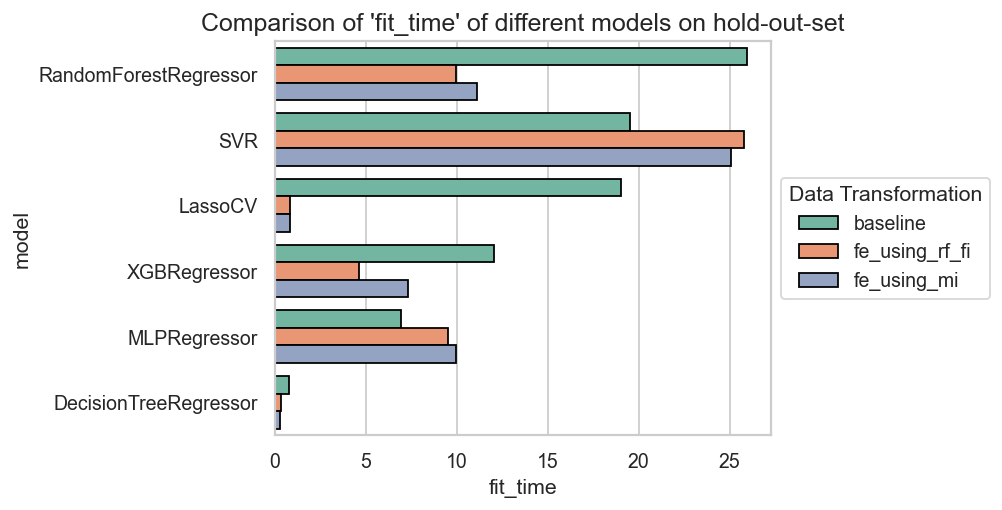

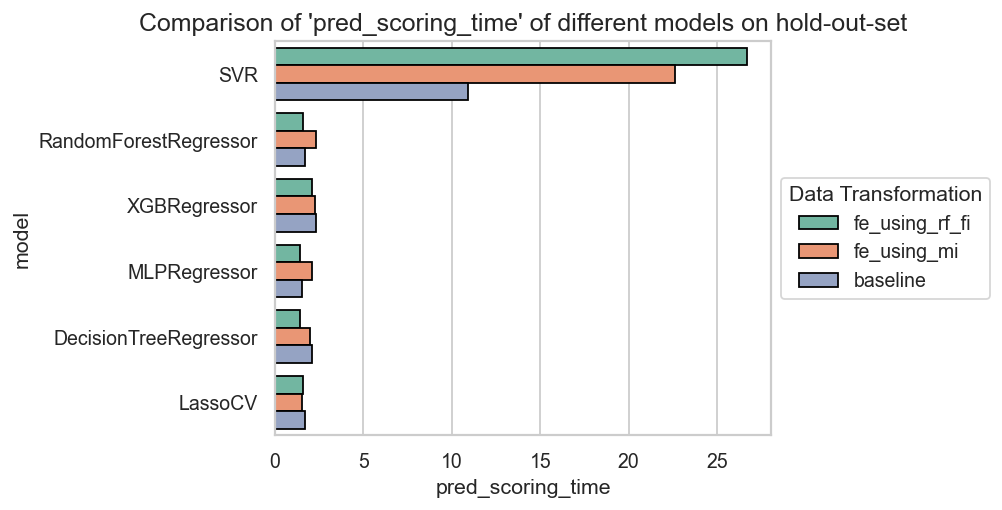

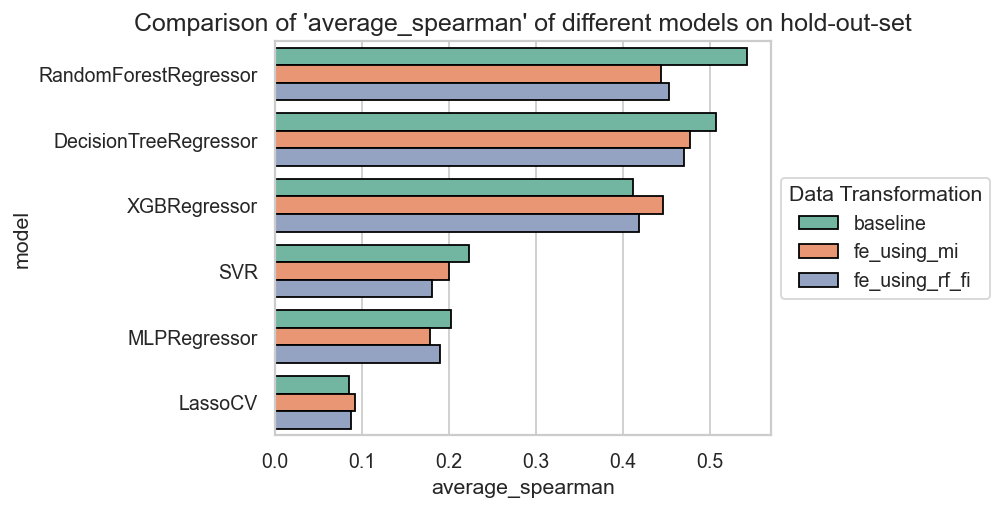

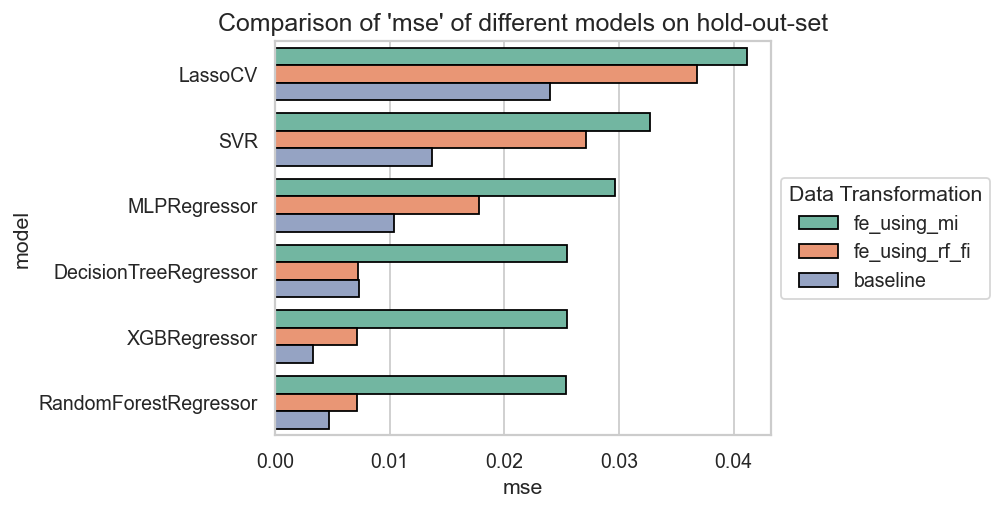

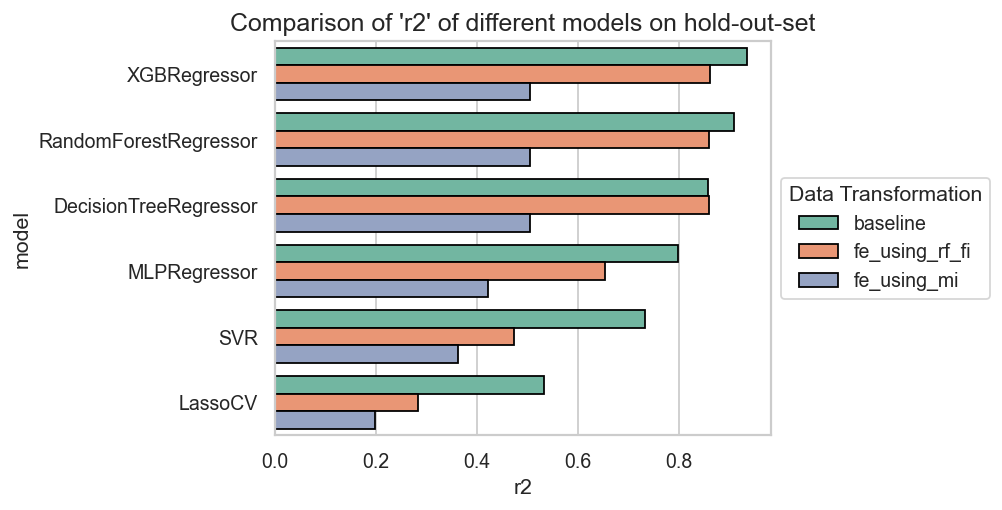

In [131]:
plot_results(res_overall, savefigs=True)